# Gradient Boosting Machine For Dummy

Gradient boosting machine provides iterative procedures to make prediction approach toward true values. In each iteration, we train a nudge model with resiudals as targe variable, and prediction is a composite value of the nudge models. Different from regular gradient descent which updates parameters by optimizing cost function 

$$\theta_i := \theta_i - \alpha \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_i}, $$


gradient boosting machine is doing gradient descent in function space, a.k.a. prediction space. see [Friedman's classic paper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). 

$$\hat{y}^{m+1}_i := \hat{y}^m_i - \alpha \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{y}^m_i}. $$



The content throughout the notebook follows a series of GBM blogs by Matt Bowers:

* [How to Build a Gradient Boosting Machine from Scratch](https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch)

* [Get Down with Gradient Descent](https://blog.mattbowers.dev/get-down-with-gradient-descent)

* [How Gradient Boosting Does Gradient Descent](https://blog.mattbowers.dev/how-gradient-boosting-does-gradient-descent)

We will write a simple code to indicate how to build a gradient boosting machine. 


## Toy Data

In [45]:
import numpy as np 
from matplotlib import pyplot as plt 
rng = np.random.default_rng()
x = np.linspace(0, 10, 50)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

In [9]:
len(x), len(y)

(50, 50)

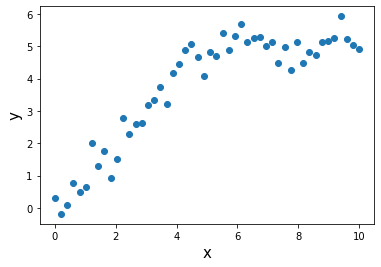

In [8]:
plt.scatter(x, y)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show();

The data shows y is not completely linear to x. 

## Gradient boosting machine

Our goal is to find a model to predict y, such that

$$F(x) = \hat{y}$$

minimizes mean squared errors 

$$\frac{1}{n}\sum^n_{i=1}\big(\mathbf{y}_i -\hat{\mathbf{y}}_i \big)^2.$$


We can initially train a simple tree, a stump by fitting x with respect to $y$: $\hat{y} = F_0(x)$. Then in the following, each stump is trained by fitting $y - \hat{y} = h(x)$, where Matt called $h(x)$ "nudge model".

| $F_m$ | fit |
| :-: | :-: | 
| $$F_0(x) = \textrm{Tree}(x)$$ | $$ h_1(x) = y - F_0(x)  $$ | 
|$$F_1(x) = F_0(x) + h_1(x) $$ | $$ h_2(x) = y - F_1(x) $$ |
|$$F_2(x) = F_1(x) + h_2(x) = \big(F_0(x) + h_1(x)\big) + h_2(x) $$ | $$ h_3(x) = y - F_2(x)$$ |
|$$F_3(x) = F_2(x) + h_3(x) = \big(F_1(x) + h_2(x)\big) + h_3(x) = F_0(x) + \sum^3_{t=1} h_t(x)$$ | $$ h_4(x) = y - F_3(x)$$ |
| $$\vdots$$ | $$\vdots$$ |
|$$F_m(x) = F_{m-1}(x) + h_m(x) = F_0(x) + \sum^m_{t=1} h_t(x) $$ | $$ h_{m+1}(x) = y - F_m(x)$$ |

We can simly define $h_0(x) = F_0(x)$. Though each nudge model $h(x)$ is a weak learner, a stump, the final composite prediction reads

$$\hat{y}=F_m(x) =  \sum^m_{i=0} h_t(x) $$ 

is contirbuted by all $h_t(x)$. The collection $\lbrace h_0, h_1, \cdots \rbrace $ form an ensemble.

## GBM Code

In [52]:
from sklearn.tree import DecisionTreeRegressor

n_trees = 10
max_depth = 1

Fm = np.mean(y)
trees = []
for t in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)
    Fm += tree.predict(x)
    trees.append(tree)

In [53]:
pred = np.mean(y)
for t in trees:
    pred += t.predict(x)

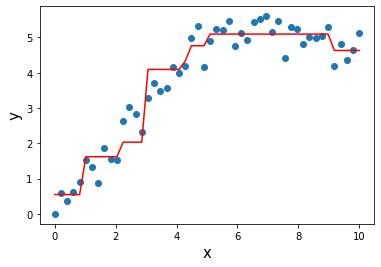

In [54]:
plt.scatter(x, y, label="data")
plt.plot(x, pred, color="red", label="GBM")
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show();

## Updating with learning rate

The above process shows how a gradient boosting machine is built. However, the directly adding procedure 

$$ \hat{y} = \sum^m_{t=0} h_t(x)$$

may be easy to cause overfitting. In this case we can add a learning rate $\alpha$ such that every iteration, prediction gradually approaches to its true value:

| $F_m$ | fit |
| :-: | :-: | 
| $$F_0(x) = \textrm{Tree}(x)$$ | $$ h_1(x) = y - F_0(x)  $$ | 
|$$F_1(x) = F_0(x) + \alpha h_1(x) $$ | $$ h_2(x) = y - F_1(x) $$ |
|$$F_2(x) = F_1(x) + \alpha h_2(x) = F_0(x) + \alpha \big[ h_1(x) + h_2(x) \big] $$ | $$ h_3(x) = y - F_2(x)$$ |
| $$\vdots$$ | $$\vdots$$ |
|$$F_m(x) = F_{m-1}(x) + \alpha h_m(x) = \alpha \sum^m_{t=0} h_t(x) $$ | $$ h_{m+1}(x) = y - F_m(x)$$ |

Wrap up it, we can create `GBMFromScratch` class to have `fit` and `predict` method:

In [60]:
class GBMFromScratch(object):
    def __init__(self, n_trees=10, alpha=0.1, max_depth=1):
        self.n_trees = n_trees
        self.alpha = alpha
        self.max_depth = max_depth
        self.model = None
        self.cost = []
    
    def fit(self, x, y):
        Fm = np.mean(y)
        self.model = [Fm]
        self.cost = []
        for t in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(x, y - Fm)
            Fm += self.alpha*tree.predict(x)
            self.model.append(tree)
            self.cost.append(self.MSE(y, self.predict(x)))
        
    def visualize_MSE(self):
        plt.plot(range(len(self.cost)), self.cost, color="red")
        plt.xlabel('iteration', fontsize=15)
        plt.ylabel('MSE', fontsize=15)
        plt.show();
        
    def predict(self, x):
        pred = self.model[0]
        for i in range(1, len(self.model)):
            pred += self.alpha*self.model[i].predict(x)
        return pred
    
    def MSE(self, y, pred):
        return sum((y-pred)**2)/len(y)

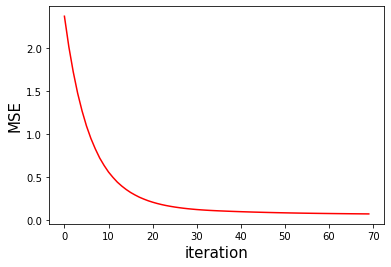

In [61]:
gbm = GBMFromScratch(n_trees=70)
gbm.fit(x, y)
gbm.visualize_MSE()

Above we see MSE decreases upon iteration. The MSE is minimized by the boosting process.

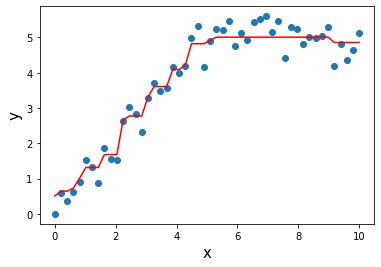

In [57]:
plt.scatter(x, y, label="data")
plt.plot(x, gbm.predict(x), color="red", label="GBM")
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show();

## Theory: "Gradient" in GBM

The discussion follows Matt's blog: [How Gradient Boosting Does Gradient Descent](https://blog.mattbowers.dev/how-gradient-boosting-does-gradient-descent)

For regression problem, the loss (cost) fucntion is MSE

$$\textrm{L}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{n}\sum^n_{i=1}\big(\mathbf{y}_i -\hat{\mathbf{y}}_i \big)^2$$


At m-th step, the prediction $\hat{y}^m_i = F_m(x_i) = \alpha \sum^{m}_{t=0} h_t(x_i)$. Next prediction will be pivot  in terms of the derivative between $ y_i$ and $\hat{y}_i$, shown below

$$\hat{y}^{m+1}_i = \hat{y}^m_i - \alpha \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{y}^m_i} = \hat{y}^m_i + \alpha G^m_i. $$

where $G^m_i$ is the gradient defined as follows

$$ G^m_i = - \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{y}^m_i} \propto (y_i - \hat{y}^m_i) $$

The intuition is that in 1D if $y_i > \hat{y}^m_i$, we need to move $\hat{y}^m_i$ larger to minimize the cost function, so we will have positive derivative (slope) $\to$ positive gradient; vice versa. Note there are n data points, so the gradient is a n-dimensional vector

$$\mathbf{G}^m = \Big[  - \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{\mathbf{y}}^m_1},   - \frac{\partial \textrm{L}(\mathbf{y},- \hat{\mathbf{y}}^m)}{\partial \hat{\mathbf{y}}^m_2}, \cdots,  - \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{\mathbf{y}}^m_n}  \Big]$$

Compare the process $\hat{\mathbf{y}}^{m+1} = \hat{\mathbf{y}}^m + \alpha \mathbf{G}^m $ and gradient boosting machine process $F_m(x) = F_{m-1}(x) + \alpha h_m(x)$ mentioned previously, **$h_m$ plays a role as the gradient to pivot prediction moving toward to the true value**

$$h_m(x) \simeq - \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}}^m)}{\partial \hat{y}^m_i}.$$



## Gradient boosting vs parameter gradient descent


For parameter gradient descent, e.g. linear regression, we have hypothesis ($p$ features)

$$\hat{y} = h_{\theta}(\mathbf{x}) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p,$$

where $\lbrace \theta_0, \theta_1, \cdots \rbrace$ are model parameters to optimize by minimizing $\textrm{L}(\mathbf{y}, \hat{\mathbf{y}})$:

$$\theta_i := \theta_i - \alpha \frac{\partial \textrm{L}(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_i}. $$

Matt summarized the difference in his [blog](https://blog.mattbowers.dev/how-gradient-boosting-does-gradient-descent). The generic gradient boosting algorithm outlined above implies two key differences from parameter gradient descent.

* Instead of nudging parameters, we nudge each individual prediction, thus instead of taking the gradient of loss with respect to the parameters, we take the gradient with respect to the predictions.

* Instead of directly adding the negative gradient to our current parameter values, we create a functional approximation of the negative gradient and add that to our model. Our functional approximation is just a crappy model that tries to use the model features to predict the negative gradient of the loss with respect to our current model predictions.

The true genius of the gradient boosting algorithm is in chasing the negative gradient of the loss with crappy models, rather than using it to directly update our predictions. We train a crappy model to predict the negative gradient of the loss with respect to the current model predictions, thus we can iteratively update our composite model by adding these crappy models to it.